In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
#import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

## Load quasar tables

In [12]:
def get_table_with_necessary(tab):
    col_names_necessary = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                           'w1mpro', 'w2mpro', 'redshift_qsoc']
    cols_necessary = []
    for col_name in col_names_necessary:
        cols_necessary.append(tab[col_name])
    cols_necessary = np.array(cols_necessary).T
    i_has_necessary = np.all(np.isfinite(cols_necessary), axis=1)
    #print(f"N with necessary data: {np.sum(i_has_necessary)} ({np.sum(i_has_necessary)/len(i_has_necessary):.3f})")
    return tab[i_has_necessary]

In [4]:
fn_gall = '../data/gaia_slim.fits'
tab_gall = utils.load_table(fn_gall)
N_data_gall = len(tab_gall)
print(f"Number of all Gaia quasar candidates: {N_data_gall}")

Number of data sources: 6649162


In [13]:
tab_gall_wnec = get_table_with_necessary(tab_gall)
print(f"Number of Gaia quasar candidates with necessary data: {len(tab_gall_wnec)}")

Number of Gaia quasar candidates with necessary data: 1555108


In [17]:
fn_gpurer = '../data/gaia_purer_sourceids.fits'
tab_gpurer = utils.load_table(fn_gaia_purer)
tab_gpurer = join(tab_gpurer, tab_gall, keys='source_id', metadata_conflicts='silent')
print(f"Number of Gaia purer samples: {len(tab_gpurer)}")
print(tab_gpurer.columns)

Number of Gaia purer samples: 1942825
<TableColumns names=('source_id','ra','dec','redshift_qsoc','l','b','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm')>


In [18]:
tab_gpurer_wnec = get_table_with_necessary(tab_gpurer)
print(f"Number of Gaia quasar candidates with necessary data: {len(tab_gpurer_wnec)}")

Number of Gaia quasar candidates with necessary data: 1325573


In [21]:
tab_gclean = utils.load_table(f'../data/gaia_clean.fits')
print(f"Number of Gaia quasars in clean sample: {len(tab_gclean)}")

Number of Gaia quasars in clean sample: 1451214


In [98]:
data_colors = {'gall': 'grey',
               'gall_wnec': 'grey',
               'gpurer': 'purple',
               'gpurer_wnec': 'purple',
               'gclean': 'black'}
data_labels = {'gall': 'Gaia quasar candidates',
               'gall_wnec': r'with unWISE and $z_\mathrm{Gaia}$',
               'gpurer': 'Gaia purer',
               'gpurer_wnec': r'with unWISE and $z_\mathrm{Gaia}$',
               'gclean': 'GaiaQ'}
data_lss =    {'gall': '--',
               'gall_wnec': '-',
               'gpurer': '--',
               'gpurer_wnec': '-',
               'gclean': '-'}
data_tables = {'gall': tab_gall,
               'gall_wnec': tab_gall_wnec,
               'gpurer': tab_gpurer,
               'gpurer_wnec': tab_gpurer_wnec,
               'gclean': tab_gclean}

In [90]:
data_names = ['gall', 'gall_wnec', 'gpurer', 'gpurer_wnec', 'gclean']

## Load in labeled data

In [27]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")

Number of SDSS quasars: 351024


In [30]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")

Number of SDSS stars: 598582


In [28]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")

Number of SDSS galaxies: 606231


## Stack into single table & arrays

In [31]:
f_train = 0.7

In [45]:
class_labels = ['q', 's', 'g']
tab_squasars['class'] = 'q'
tab_sstars['class'] = 's'
tab_sgals['class'] = 'g'

In [35]:
cols_tokeep = ['source_id', 'class', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
               'mag_w1_vg', 'mag_w2_vg']
tab_squasars_lite = tab_squasars.copy()
tab_sstars_lite = tab_sstars.copy()
tab_sgals_lite = tab_sgals.copy()

tab_squasars_lite.keep_columns(cols_tokeep)
tab_sstars_lite.keep_columns(cols_tokeep)
tab_sgals_lite.keep_columns(cols_tokeep)

In [37]:
tab_labeled = astropy.table.vstack([tab_squasars_lite, tab_sstars_lite, tab_sgals_lite], metadata_conflicts='silent')

In [38]:
print(len(tab_labeled))
print(tab_labeled.columns)

1555837
<TableColumns names=('source_id','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','mag_w1_vg','mag_w2_vg','class')>


In [39]:
source_ids = np.array(tab_labeled['source_id'])
classes = np.array(tab_labeled['class'])

In [40]:
N_labeled = len(classes)
print(N_labeled)

1555837


In [41]:
rand_ints = rng.choice(np.arange(N_labeled), size=N_labeled, replace=False)
i_train = rand_ints < int(f_train*N_labeled)
i_valid = ~i_train

In [42]:
np.sum(i_train), np.sum(i_valid)

(1089085, 466752)

In [43]:
source_ids_train = source_ids[i_train]
source_ids_valid = source_ids[i_valid]

classes_train = classes[i_train]
classes_valid = classes[i_valid]

In [46]:
class_nums = [np.sum(classes_valid==c) for c in class_labels]
class_fracs = class_nums/np.sum(class_nums)
print(class_fracs)

[0.2248196  0.3853074  0.38987299]


## get confusion matrices

In [47]:
# assumes all s_ids_pred_target are in target class (bc we're labeling all of our catalog 'quasars')
def get_classes(s_ids_pred_target, s_ids_valid, c_valid, target='q'):
    s_ids_pred_target = np.array(s_ids_pred_target)
    # Get which sources in validation set are in the predicted catalog
    i_in_pred = np.isin(s_ids_valid, s_ids_pred_target)
    # The predicted catalog is all targets; non-targets are other ('o')
    # okay making them all stars for now, dont know what to do when have gals too??
    c_pred = np.full(len(c_valid), 's')
    c_pred[i_in_pred] = target
    return c_pred

In [48]:
def confusion_matrix(C_pred, C_true, labels, priors=None, class_fracs=None):
    
    N_classes = len(labels)
    conf_mat = np.empty((N_classes, N_classes))
    for i in range(N_classes):
        for j in range(N_classes):
            conf_mat[i, j] = np.sum((C_true==labels[i]) & (C_pred==labels[j]))
    
    if priors is not None and class_fracs is None:
        assert len(priors)==N_classes
        priors_norm = priors/np.sum(priors)
        for i in range(N_classes):
            conf_mat[i] *= priors_norm[i]
    
    if class_fracs is not None:
        assert len(class_fracs)==N_classes
        if priors is None:
            priors = np.ones(N_classes)
        priors_norm = priors/np.sum(priors)      
        class_fracs_norm = class_fracs/np.sum(class_fracs)
        
        denominator = np.sum(priors_norm/class_fracs_norm)
        lambdas = priors_norm/class_fracs_norm * 1/denominator
        for i in range(N_classes):
            conf_mat[i] *= lambdas[i]   
    
    return conf_mat

In [49]:
def N_FP(conf_mat, label='q'):
    i = class_labels.index(label)
    FP = np.sum([conf_mat[j,i] for j in range(len(class_labels)) if j!=i])
    return FP

In [50]:
def N_FN(conf_mat, label='q'):
    i = class_labels.index(label)
    FN = np.sum([conf_mat[i,j] for j in range(len(class_labels)) if j!=i])
    return FN

In [51]:
def purity(conf_mat, label='q'):
    i = class_labels.index(label)
    TP = conf_mat[i,i]
    FP = np.sum([conf_mat[j,i] for j in range(len(class_labels)) if j!=i])
    return TP/(TP+FP)

In [52]:
def completeness(conf_mat, label='q'):
    i = class_labels.index(label)
    TP = conf_mat[i,i]
    FN = np.sum([conf_mat[i,j] for j in range(len(class_labels)) if j!=i])
    return TP/(TP+FN)

In [55]:
conf_mats_raw = []
for tab in tabs_data:
    c_pred = get_classes(tab['source_id'], source_ids_valid, classes_valid)
    conf_mat_raw = confusion_matrix(c_pred, classes_valid, class_labels)
    conf_mats_raw.append(conf_mat_raw)

In [56]:
fps = []
for i, conf_mat_raw in enumerate(conf_mats_raw):
    fp = N_FP(conf_mat_raw, label='q')
    fps.append(fp)

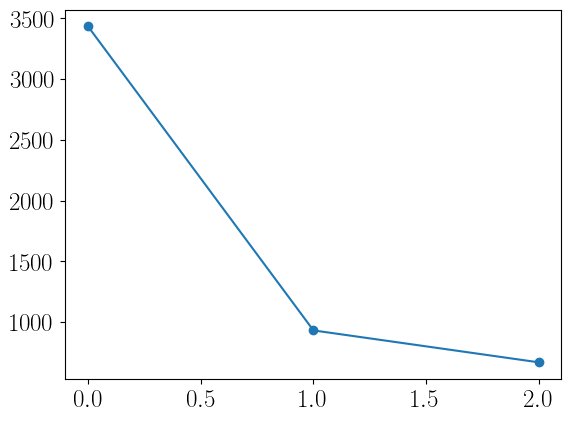

In [57]:
plt.plot(fps, marker='o')

In [95]:
G_cuts = np.arange(17, 21.5, 0.5)

conf_mats_raw = []
fp_arr = []
comp_arr = []
for i, name in enumerate(data_names):
    tab = data_tables[name]
    fps = []
    comps = []
    for G_cut in G_cuts:
        i_makesGcut = tab['phot_g_mean_mag'] < G_cut
        tab_Gcut = tab[i_makesGcut]
        c_pred = get_classes(tab_Gcut['source_id'], source_ids_valid, classes_valid)
        conf_mat_raw = confusion_matrix(c_pred, classes_valid, class_labels)
        fps.append( N_FP(conf_mat_raw, label='q') )
        comps.append( completeness(conf_mat_raw, label='q') )
    fp_arr.append(fps)
    comp_arr.append(comps)

Text(0, 0.5, 'number of contaminants')

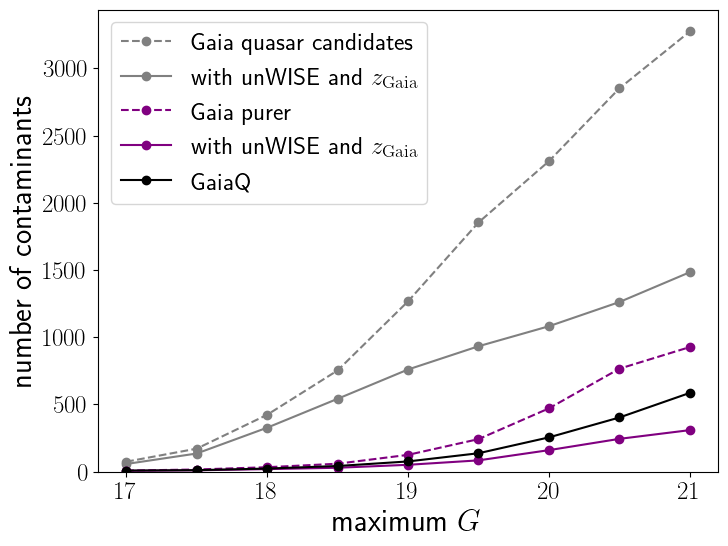

In [100]:
plt.figure(figsize=(8,6))
for i, name in enumerate(data_names):
    plt.plot(G_cuts, fp_arr[i], marker='o', label=data_labels[name],
             color=data_colors[name], ls=data_lss[name])
plt.legend()
plt.ylim(0)

plt.xlabel(f'maximum $G$')
plt.ylabel("number of contaminants")

Text(0, 0.5, 'completeness')

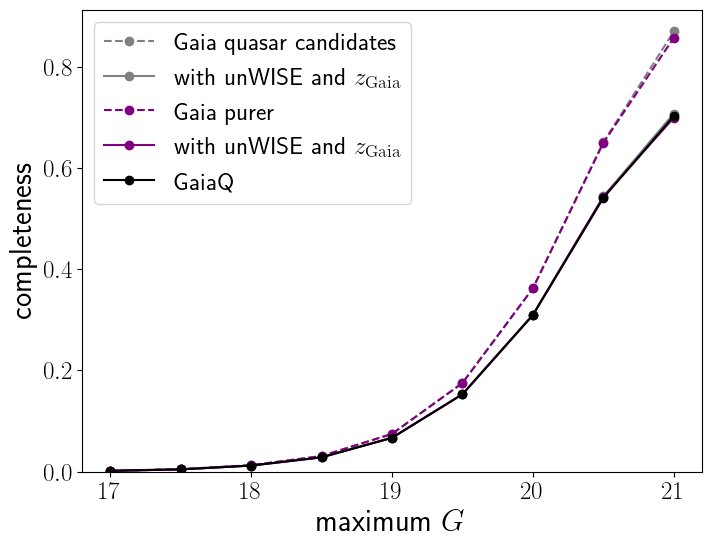

In [101]:
plt.figure(figsize=(8,6))
for i, name in enumerate(data_names):
    plt.plot(G_cuts, comp_arr[i], marker='o', label=data_labels[name],
             color=data_colors[name], ls=data_lss[name])
plt.legend()
plt.ylim(0)

plt.xlabel(f'maximum $G$')
plt.ylabel('completeness')